# Political trends of main polish news portals

## Assumption
Polish media aren't objective and represent one of 2 mainstream political orientation.

Based on titles of the articles published on various polis news portals
we are able to classify what is the political direction represented.
The knowledge about political orientation is important because:
- we know which media we're keen to follow
- we know which of the media are objective
- we can evaluate media reliability 

# The algorithm
1. Prepare reference dataset - we often know that given media is oriented to one of the political party therefore we can select those pages and treat them as training dataset
2. Using NLP technique prepare the model of media - based on different methods we'll select the model that have highest accuracy of classification
3. Classify other selected media - we'll use the best model to classify other media for which the political direction isn't obvious
4. Analyze sentiment of the media - sentiment analysis for polish language is not yet standarized, experimental dataset will be used



# Prerequisities

Install and download required libraries and datasets

In [1]:
# Uncoment below lines to install required libraries

# !python -m pip install --upgrade pip

# !python -m pip install --user spacy==3.0.6
# !python -m pip install --user tqdm==4.56.2
# !python -m pip install --user gensim==4.0.1
# !python -m pip install --user numpy==1.9.15
# !python -m pip install --user pandas==1.2.1
# !python -m pip install --user xgboost==1.4.2
# !python -m pip install --user seaborn==0.11.1
# !python -m pip install --user sklearn==0.24.1
# !python -m pip install --user autokeras==1.0.13
# !python -m pip install --user matplotlib==3.3.3
# !python -m pip install --user beautifulsoup4==4.9.3
# !python -m pip install --user python-Levenshtein==0.12.2

# For development mode use smalled dataset
# !python -m spacy download pl_core_news_sm

# For production mode use bigger dataset
# !python -m spacy download pl_core_news_md


In [2]:
import numpy as np
import spacy as sp
import pandas as pd
import seaborn as sns
import autokeras as ak
import matplotlib.pyplot as plt

import math, multiprocessing, os, random, requests, re

from tqdm import tqdm
from sklearn import utils
from bs4 import BeautifulSoup
from gensim.models import Doc2Vec
from IPython.display import display
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

DEVELOPMENT = False

# Load SpaCy NLP model
if DEVELOPMENT:
    nlp = sp.load("pl_core_news_sm")
else:
    nlp = sp.load("pl_core_news_md")

# Color helper class
class c:
    END = '\033[1;37;0m'
    RED = '\033[1;31;48m'
    BLUE = '\033[1;34;48m'
    GREEN = '\033[1;32;48m'

# Setting seed for repetitive simulations
SEED = 142857
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = f"{SEED}"


# Helper methods


In [3]:
# Cleaning text
def text_clean(text):
    text = text.replace("\n", " ")           # no new lines
    text = re.sub(r"[\W]", ' ', text)        # words only
    text = re.sub(r"\s+", ' ', text)         # no spaces
    text = re.sub(r"\s+\d+\s+", ' ', text)   # no standalone numbers

    return text.strip().lower()

# Custom tokenization function
def tokenize(text):
    return text.split()

# Training dataset preparation


In [4]:
# We'll scrape data from pages therefore we'll pretend real browser
  
header = {
    "Connection": "keep-alive",
    "DNT": "1",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "Sec-Fetch-Site": "none",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-Dest": "document",
    "Referer": "*",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "pl-PL,en-GB,en-US;q=0.9,pl;q=0.8,en;q=0.7"
}

In [5]:
urls = {
    # Media considered as left-wing
    "http://lewica.pl/": "L",
    "https://oko.press/": "L",
    "https://koduj24.pl/": "L",
    "https://wpunkt.online/": "L",
    "https://www.tygodnikprzeglad.pl/": "L",

    # Media considered as right-wing
    "https://dorzeczy.pl/": "R",
    "https://www.gosc.pl/": "R",
    "https://www.tvp.info/": "R",
    "https://www.niezalezna.pl/": "R",
}

filtered = []

# read headers and store them in dataframe
for url, lr in urls.items():
    header["Referer"] = url

    # Get page contents for given url
    r = requests.Session()
    r.headers = header
    page = r.get(url)

    if lr == "L": print(f"Parsing {c.RED} {url} {c.END}")
    else: print(f"Parsing {c.GREEN} {url} {c.END}")

    if page.status_code != 200: continue

    soup = BeautifulSoup(page.text, 'html.parser')
    links = soup.find_all('a', href=True)
    
    # some initial cleaning
    for link in links:
        text = link.text

        # remove empty links
        if len(link['href']) == 0 or len(text.strip()) == 0: continue
        # filter out external links - we don't analyze other pages
        if link['href'][0] != '/' and url not in link['href']: continue
        # filter out one and two-words links
        if len(text.split()) <= 2: continue

        # additional cleaning
        text = text_clean(text)
            
        filtered.append([text, lr])

# Initial dataframe
df = pd.DataFrame(filtered, columns=['text', 'lr'])


Parsing  http://lewica.pl/ 
Parsing  https://oko.press/ 
Parsing  https://koduj24.pl/ 
Parsing  https://wpunkt.online/ 
Parsing  https://www.tygodnikprzeglad.pl/ 
Parsing  https://dorzeczy.pl/ 
Parsing  https://www.gosc.pl/ 
Parsing  https://www.tvp.info/ 
Parsing  https://www.niezalezna.pl/ 


# Additional data preparation
- Stopwords removal
- Lemmatization


In [6]:
# Remove texts that we know they don't add any value like: "zobacz więcej"
def text_clean_additional(text):
    text = text.replace("zobacz więcej", " ")
    text = text.replace("kliknij", " ")
    text = text.replace("ii", " ")
    text = text.replace("iii", " ")
    text = text.replace("iv", " ")

    return text.strip().lower()

In [7]:
# remove stopwords
def stopwords_remove(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])
    
# lemmatize sentences
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df['cleaned'] = df.text.apply(stopwords_remove)
df['cleaned'] = df.cleaned.apply(text_clean_additional)
df['lemmatized'] = df.cleaned.apply(lemmatize)
df['idx'] = df.index

In [8]:
# remove ambiguous texts (same for 2 categories L and R)
duplicated = df[df.duplicated(['lemmatized'], keep=False)].lemmatized.unique()
df = df[~df.lemmatized.isin(duplicated)]


In [9]:
# Data quick look to see if everything is transformed properly
with pd.option_context('display.max_colwidth', None):
    if DEVELOPMENT:
        display(df.sample(5))
    else:
        display(df.head(3))

,text,lr,cleaned,lemmatized,idx
0,wideo tusk wzywa polaków do mobilizacji musimy ratować kraj,L,wideo tusk wzywa polaków mobilizacji musimy ratować kraj,wideo tusk wzywać polak mobilizacja musić ratować kraj,0
1,wyrok trybunału przyłębskiej szefowa komisji europejskiej ursula von der leyen komentuje,L,wyrok trybunału przyłębskiej szefowa komisji europejskiej ursula von der leyen komentuje,wyrok trybunał przyłębskiej szefowa komisja europejski ursula von dera leyen komentować,1
2,straż graniczna ze strony białoruskiej padły strzały do polskich żołnierzy,L,straż graniczna strony białoruskiej padły strzały polskich żołnierzy,straż graniczna strona białoruski paść strzała polski żołnierz,2


# ML dataset preparation

In [10]:
train, test = train_test_split(df, test_size=0.3, random_state=SEED)

train_tagged = train.apply(lambda _: TaggedDocument(words=tokenize(_.lemmatized), tags=[_.lr, _.idx]), axis=1)
test_tagged = test.apply(lambda _: TaggedDocument(words=tokenize(_.lemmatized), tags=[_.lr, _.idx]), axis=1)


In [11]:
# Check how many processors we can use

cores = multiprocessing.cpu_count()
print(f"Cores: {c.GREEN} {cores} {c.END}")


Cores:  8 


## Doc2vec preparation 
Create a vectorised representation of a group of words in the text as one vector


In [12]:
PV_DBOW = 0  # draw words from the paragraph
PV_DM = 1    # draw words from surround words of the target word

# https://radimrehurek.com/gensim/models/doc2vec.html
dbow = Doc2Vec(dm=PV_DBOW, vector_size=100, negative=5, min_count=2, workers=cores, seed=SEED)
dbow.build_vocab([x for x in tqdm(train_tagged.values)])

input = utils.shuffle([x for x in train_tagged.values], random_state=SEED)
dbow.train(input, total_examples=len(train_tagged.values), epochs=100)


100%|██████████| 254/254 [00:00<?, ?it/s]


In [13]:
# Prepare train-test datasets
def prepare_datasets(model, tagged_docs):
    docs = tagged_docs.values
    _, __, ___= zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100), doc.tags[1]) for doc in docs])
    return _, __, ___

y_train, x_train, i_train = prepare_datasets(dbow, train_tagged)
y_test, x_test, i_test = prepare_datasets(dbow, test_tagged)


# Models evaluation


In [14]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
encoder.fit(['L', 'R'])

models = [
    GaussianNB(), 
    KNeighborsClassifier(2),
    LogisticRegression(random_state=SEED),
    AdaBoostClassifier(random_state=SEED), 
    SVC(gamma=2, C=1, probability=True, random_state=SEED),
    DecisionTreeClassifier(max_depth=5, random_state=SEED), 
    MLPClassifier(alpha=1, max_iter=1000, random_state=SEED), 
    SVC(kernel="linear", C=0.025, probability=True, random_state=SEED),
    XGBClassifier(use_label_encoder=False, eval_metric='merror', random_state=SEED),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=SEED),          
    ExtraTreesClassifier(n_estimators=20, max_depth=10, min_samples_split=4, random_state=SEED)
]

from sklearn.ensemble import VotingClassifier
estimators = [(type(m).__name__ + f"_{str(id(m))}", m) for m in models]

voter = VotingClassifier(estimators=estimators, voting ='hard')
voter.fit(np.array(x_train), encoder.transform(y_train))
y_pred = voter.predict(np.array(x_test))

score = accuracy_score(encoder.transform(y_test), y_pred)
print(f"Voted accuracy score:{c.BLUE} {format(score, '.3f')} {c.END}")

for model in models:
    model.fit(np.array(x_train), encoder.transform(y_train))  
    y_pred = model.predict(np.array(x_test))

    score = accuracy_score(np.array(y_test), encoder.inverse_transform(y_pred))

    print(f"Testing accuracy score:{c.BLUE} {format(score, '.3f')} {c.END}   {type(model).__name__}")    
 

Voted accuracy score: 0.679 
Testing accuracy score: 0.596    GaussianNB
Testing accuracy score: 0.560    KNeighborsClassifier
Testing accuracy score: 0.661    LogisticRegression
Testing accuracy score: 0.624    AdaBoostClassifier
Testing accuracy score: 0.642    SVC
Testing accuracy score: 0.606    DecisionTreeClassifier
Testing accuracy score: 0.670    MLPClassifier
Testing accuracy score: 0.651    SVC
Testing accuracy score: 0.661    XGBClassifier
Testing accuracy score: 0.670    RandomForestClassifier
Testing accuracy score: 0.679    ExtraTreesClassifier


In [15]:
# Grid search to find best model hyperparameters
# This will change previous cell model parameters 
# We'll take the best model from above and fine-tune it
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [5, 10, 20], 'max_depth': [5, 10, 20, None], 'min_samples_split' : [4, 6, 8]}
base_estimator = ExtraTreesClassifier(random_state=SEED)

scores = ['precision', 'recall', 'accuracy', 'f1']

for score in scores:
    gsc = GridSearchCV(base_estimator, param_grid, scoring='%s' % score)
    gsc.fit(np.array(x_train), encoder.transform(y_train))

    print(f"Best parameters found on development set: {score}")
    print(gsc.best_params_)
    print()
    print("Grid scores on development set")
    means = gsc.cv_results_['mean_test_score']
    stds = gsc.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

Best parameters found on development set: precision
{'max_depth': 20, 'min_samples_split': 8, 'n_estimators': 20}

Grid scores on development set
0.897 (+/-0.129) for {'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 5}
0.914 (+/-0.048) for {'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 10}
0.939 (+/-0.072) for {'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 20}
0.883 (+/-0.148) for {'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 5}
0.899 (+/-0.059) for {'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 10}
0.939 (+/-0.073) for {'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 20}
0.893 (+/-0.162) for {'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 5}
0.897 (+/-0.078) for {'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 10}
0.931 (+/-0.047) for {'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 20}
0.906 (+/-0.066) for {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 5}
0.910 (+/-0.063) for {'max_depth': 10

# Autokeras model evaluation


In [16]:
trials = 5 if DEVELOPMENT else 100
epochs = 5 if DEVELOPMENT else 10

clf = ak.StructuredDataClassifier(
    overwrite=True, max_trials=trials, seed=SEED
)

clf.fit(np.array(x_train), np.array(y_train), epochs=epochs)
y_pred = clf.predict(np.array(x_test))

print()
print(dict(zip(["Loss", "Acc"], clf.evaluate(np.array(x_test), np.array(y_test)))))



Trial 55 Complete [00h 00m 08s]
val_accuracy: 0.8666666746139526

Best val_accuracy So Far: 0.9333333373069763
Total elapsed time: 00h 08m 07s
INFO:tensorflow:Oracle triggered exit


Epoch 1/10
8/8 [==============================] - 2s 3ms/step - loss: 0.5222 - accuracy: 0.8189
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 0.3077 - accuracy: 0.8740
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.2564 - accuracy: 0.8701
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2406 - accuracy: 0.8661
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2275 - accuracy: 0.8740
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.2155 - accuracy: 0.8819
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.2056 - accuracy: 0.8858
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.1969 - accuracy: 0.9016
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.1890 - accuracy: 0.9094
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.1816 - accuracy: 0.9094
INFO:tensorflow:Assets written to: .\st

In [17]:
h5 = clf.export_model()
h5.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 100)               0         
_________________________________________________________________
normalization (Normalization (None, 100)               201       
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33792     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1024)              0     

In [18]:
# Check how articles are classified 
def labelize(row):
    if row.y_test == 'L' and row.y_pred == 'L': return 'TN'
    if row.y_test == 'L' and row.y_pred == 'R': return 'FP'
    if row.y_test == 'R' and row.y_pred == 'L': return 'FN'
    if row.y_test == 'R' and row.y_pred == 'R': return 'TP'

    return ''

predictions = [(_[0], _[1][0], _[2]) for _ in list(zip(y_test, y_pred.tolist(), i_test))]
predictions = pd.DataFrame(predictions, columns=["y_test", "y_pred", "i_test"])
predictions['labels'] = predictions.apply(labelize, axis=1)

with pd.option_context('display.max_colwidth', None):
    display(pd.merge(predictions, df[['text', 'idx']], left_on='i_test', right_on='idx').drop(['i_test', 'idx'], axis=1))

,y_test,y_pred,labels,text
0,R,L,FN,polska to więcej
1,L,L,TN,pokolenie pozytywnych indywidualistów
2,L,L,TN,zarobić na polskim wzornictwie
3,R,R,TP,prezes nbp o podwyżce stóp procentowych walczymy o bezpieczną przyszłość zacieśnienie polityki pieniężnej przez nas musi być ostrożne musi być rozważne zobacz więcej
4,R,L,FN,krzysztof karnkowski rozdwojenie europy
...,...,...,...,...
104,L,L,TN,w berlinie mieszkanie prawem nie towarem
105,R,L,FN,eucharystia ocali świat kongresy eucharystyczne są nie tylko wydarzeniem są uzdrawiającym dotknięciem
106,R,L,FN,papież franciszek na słowacji
107,R,L,FN,zobaczwszystkie group created with sketch


## Confusion matrix

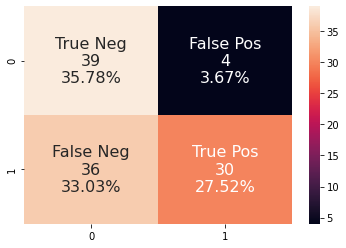

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)

cm_labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
cm_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
cm_percent = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_labels, cm_counts, cm_percent)]
labels = np.asarray(labels).reshape(2,2)

_ = sns.heatmap(cm_df, annot=labels, fmt="", annot_kws={"size": 16})


# Classify other media using the best model  

In [20]:
# unseen data classification
unseen = [
    'https://tvn24.pl/',
    'https://www.o2.pl/',
    'https://www.onet.pl/',
    'https://www.fakt.pl/',
    'https://www.wykop.pl/',
    'https://www.gazeta.pl/',
    'https://www.wprost.pl/',
    'https://www.interia.pl/',
    'https://www.pudelek.pl/',
    'https://www.polsatnews.pl/',
]

filtered_unseen = []
unseen_vectors = []

r = requests.Session()
r.headers = header

for url in unseen:
    header["Referer"] = url
    page = r.get(url)

    print(f"Parsing {c.BLUE} {url} {c.END}")

    soup = BeautifulSoup(page.text, 'html.parser')
    links = soup.find_all('a', href=True)
    
    # some initial cleaning
    for link in links:
        text = link.text

        # remove empty links
        if len(link['href']) == 0 or len(text) == 0: continue
        # filter out external links
        if link['href'][0] != '/' and url not in link['href']: continue
        # filter out one and two-words links
        if len(text.split()) <= 2: continue

        # additional cleaning
        text = text_clean(text)

        cleaned = stopwords_remove(text)
        lemmatized = lemmatize(cleaned)

        vector = dbow.infer_vector(lemmatized.split())
        unseen_vectors.append(vector)

        filtered_unseen.append([url, text])

# classify unseen data
pred = clf.predict(np.array(unseen_vectors)) 

# unseen datframe preparation
unseen_df = pd.DataFrame(filtered_unseen, columns=['url', 'text'])
unseen_df['pred'] = pred

unseen_df = unseen_df.groupby(['url', 'pred'], as_index=False).count().reset_index()
unseen_df.text = unseen_df.text.astype(float)

Parsing  https://tvn24.pl/ 
Parsing  https://www.o2.pl/ 
Parsing  https://www.onet.pl/ 
Parsing  https://www.fakt.pl/ 
Parsing  https://www.wykop.pl/ 
Parsing  https://www.gazeta.pl/ 
Parsing  https://www.wprost.pl/ 
Parsing  https://www.interia.pl/ 
Parsing  https://www.pudelek.pl/ 
Parsing  https://www.polsatnews.pl/ 
23/23 [==============================] - 0s 4ms/step


# Results of classification


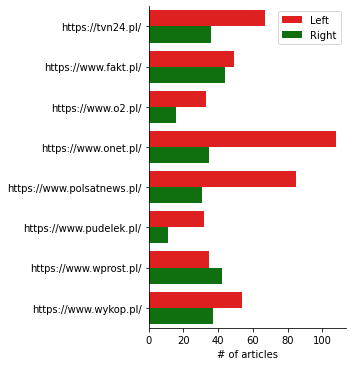

In [21]:
g = sns.catplot(
    data=unseen_df, 
    kind="bar",
    x="text", 
    y="url",
    hue="pred", 
    height=5,
    palette=sns.color_palette(['red', 'green']),
    legend_out=False
)

g.set_axis_labels("# of articles", "")
g.legend.set_title("")
for t, l in zip(g.legend.texts, ["Left", "Right"]): t.set_text(l)


In [22]:
summary_table = unseen_df.pivot(index='url', columns='pred', values='text').reset_index()
summary_table


pred,url,L,R
0,https://tvn24.pl/,67.0,36.0
1,https://www.fakt.pl/,49.0,44.0
2,https://www.o2.pl/,33.0,16.0
3,https://www.onet.pl/,108.0,35.0
4,https://www.polsatnews.pl/,85.0,31.0
5,https://www.pudelek.pl/,32.0,11.0
6,https://www.wprost.pl/,35.0,42.0
7,https://www.wykop.pl/,54.0,37.0


# Sentiment analysis

In [23]:
# Load NAWL experimental lexicon 
nawl_file = 'data/nawl-analysis.csv'
nawl = pd.read_csv(nawl_file)

nawl = nawl[['word', 'mean Happiness', 'mean Anger', 'mean Sadness', 'mean Fear', 'mean Disgust']]
nawl.columns = ['word', 'happiness', 'anger', 'sadness', 'fear', 'disgust']


In [24]:
# we look for positive and negative sentiment only
nawl_h = nawl[['word', 'happiness']].to_dict('records')
nawl_h = {d['word']: d['happiness'] for d in nawl_h}

nawl_s = nawl[['word', 'sadness']].to_dict('records')
nawl_s = {d['word']: d['sadness'] for d in nawl_s}


In [25]:
links = pd.DataFrame(filtered_unseen, columns=['url', 'text'])

sents = []
for _, row in links.iterrows():
    list_of_words = row.text.split()
    h_sents = np.sum([nawl_h.setdefault(w, 0) for w in list_of_words]) / len(list_of_words)
    s_sents = np.sum([nawl_s.setdefault(w, 0) for w in list_of_words]) / len(list_of_words)
    sents.append([h_sents, s_sents, row.url, row.text])


In [26]:
# Normalize the score to be between -1 and 1 using an alpha as the max expected value
def normalize_range(score, alpha=15):
    norm_score = score / math.sqrt((score * score) + alpha)
    return norm_score

sent_df = pd.DataFrame(sents, columns=['pos', 'neg', 'url', 'text'])
sent_df['norm_pos'] = sent_df.pos.apply(normalize_range)
sent_df['norm_neg'] = sent_df.neg.apply(normalize_range)

sent_grouped = sent_df[['url', 'text', 'norm_pos', 'norm_neg']].groupby(['url'], as_index=False).mean().reset_index().drop('index', axis=1)

sent_melted = pd.melt(sent_grouped, id_vars="url", var_name="sent_direction", value_name="sent_magnitude")


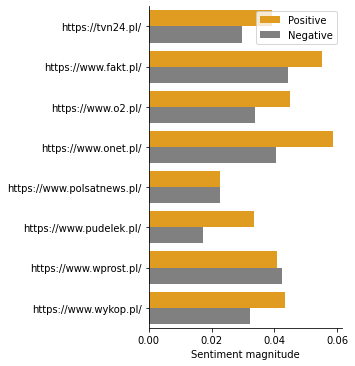

In [27]:
g = sns.catplot(
    x='sent_magnitude', 
    y='url', 
    hue='sent_direction', 
    data=sent_melted, 
    kind='bar', 
    palette=sns.color_palette(['orange', 'gray']),
    legend_out=False
)

g.set_axis_labels("Sentiment magnitude", "")
g.legend.set_title("")
for t, l in zip(g.legend.texts, ["Positive", "Negative"]): t.set_text(l)


In [28]:
sent_grouped

,url,norm_pos,norm_neg
0,https://tvn24.pl/,0.039143,0.029783
1,https://www.fakt.pl/,0.055093,0.044399
2,https://www.o2.pl/,0.044887,0.033903
3,https://www.onet.pl/,0.058589,0.040373
4,https://www.polsatnews.pl/,0.022576,0.022647
5,https://www.pudelek.pl/,0.033638,0.017152
6,https://www.wprost.pl/,0.040796,0.042511
7,https://www.wykop.pl/,0.043464,0.032131


In [29]:
# Most positive articles
with pd.option_context('display.max_colwidth', None):
    display(sent_df.sort_values(by=['norm_pos'], axis=0, ascending=False).head(10))


,pos,neg,url,text,norm_pos,norm_neg
295,3.934473,1.381766,https://www.fakt.pl/,dom i ogród,0.712654,0.336025
200,2.071795,0.597151,https://www.onet.pl/,świetny występ polaka mamy złoto,0.471687,0.152383
186,2.071225,0.980769,https://www.onet.pl/,letni chłopiec uratował dziecko,0.471587,0.245485
7,1.641026,0.948718,https://tvn24.pl/,polska i świat,0.390135,0.237924
296,1.530864,0.666667,https://www.fakt.pl/,ciąża i dziecko,0.367593,0.169638
277,1.399335,0.643162,https://www.onet.pl/,na to uczelnia rydzyka dostała pieniądze,0.339807,0.163820
706,1.288462,1.384615,https://www.polsatnews.pl/,powstanie warszawskie,0.315669,0.336640
397,1.276591,1.192783,https://www.wykop.pl/,globalny podatek minimalny jest porozumienie krajów,0.313047,0.294333
169,1.181909,0.933974,https://www.onet.pl/,zgon w wannie i seks za pieniądze wyznania byłego recepcjonisty,0.291879,0.234431
286,1.141026,0.572887,https://www.onet.pl/,tajemnica lotu mh370 co zrobił pilot,0.282602,0.146327


In [30]:
# Most negative articles
with pd.option_context('display.max_colwidth', None):
    display(sent_df.sort_values(by=['norm_neg'], axis=0, ascending=False).head(10))

,pos,neg,url,text,norm_pos,norm_neg
706,1.288462,1.384615,https://www.polsatnews.pl/,powstanie warszawskie,0.315669,0.336640
295,3.934473,1.381766,https://www.fakt.pl/,dom i ogród,0.712654,0.336025
375,0.461538,1.282051,https://www.fakt.pl/,podatek od reklam,0.118331,0.314254
461,1.019409,1.238693,https://www.wykop.pl/,wojna sztuka i polityka skutki bitwy pod orszą,0.254541,0.304628
397,1.276591,1.192783,https://www.wykop.pl/,globalny podatek minimalny jest porozumienie krajów,0.313047,0.294333
70,0.346154,1.192308,https://tvn24.pl/,możecie zacząć sami żałować,0.089022,0.294226
264,0.398148,1.083333,https://www.onet.pl/,dramat mieszkańców podwarszawskiej wsi,0.102262,0.269376
186,2.071225,0.980769,https://www.onet.pl/,letni chłopiec uratował dziecko,0.471587,0.245485
7,1.641026,0.948718,https://tvn24.pl/,polska i świat,0.390135,0.237924
46,0.506173,0.938272,https://tvn24.pl/,senat reaguje na wyrok trybunału konstytucyjnego,0.129591,0.235450
